<a href="https://colab.research.google.com/github/cm2435/Coding-Interviews/blob/main/Ravelin_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Producing Dataframe of features for EDA from the JSON file 

In [388]:
!wget https://github.com/unravelin/code-test-data-science/blob/master/customers.json

--2021-03-30 22:50:14--  https://github.com/unravelin/code-test-data-science/blob/master/customers.json
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘customers.json.7’

customers.json.7        [ <=>                ] 649.96K  --.-KB/s    in 0.04s   

2021-03-30 22:50:14 (14.3 MB/s) - ‘customers.json.7’ saved [665555]



In [389]:
import pandas as pd
import numpy as np
import sklearn as sk 

import requests
from pandas.io.json import json_normalize
import json

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

%matplotlib inline
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


In [390]:
#load in the data, I put it in local folder instead of using the WGET downloaded file from github because of issues with JSON.
data = pd.read_json("/content/test.json", lines= True)
data.head(5)

,fraudulent,customer,orders,paymentMethods,transactions
0,False,"{'customerEmail': 'josephhoward@yahoo.com', 'c...","[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb..."
1,True,"{'customerEmail': 'evansjeffery@yahoo.com', 'c...","[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg..."
2,False,"{'customerEmail': 'andersonwilliam@yahoo.com',...","[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3..."
3,False,"{'customerEmail': 'rubenjuarez@yahoo.com', 'cu...","[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz..."
4,True,"{'customerEmail': 'uchen@malone.com', 'custome...","[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h..."


In [391]:
def flatten_json(nested_json: dict, exclude: list=[''], sep: str='_') -> dict:
    """
    Flatten a list of nested dicts.
    """
    out = dict()
    def flatten(x: (list, dict, str), name: str='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude:
                    flatten(x[a], f'{name}{a}{sep}')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, f'{name}{i}{sep}')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [392]:
orders = pd.DataFrame([flatten_json(x) for x in data['orders']])
customers = pd.DataFrame([flatten_json(x) for x in data['customer']])
payment_method = pd.DataFrame([flatten_json(x) for x in data['paymentMethods']])
transactions = pd.DataFrame([flatten_json(x) for x in data['transactions']])
fraudulent = data['fraudulent']

In [393]:
#Applying the flatten json so that all features can be concated to one dataframe for usage

combined_data = pd.concat([orders, customers, payment_method, transactions, fraudulent], axis=1)
combined_data.head(3)

,0_orderId,0_orderAmount,0_orderState,0_orderShippingAddress,1_orderId,1_orderAmount,1_orderState,1_orderShippingAddress,2_orderId,2_orderAmount,2_orderState,2_orderShippingAddress,3_orderId,3_orderAmount,3_orderState,3_orderShippingAddress,4_orderId,4_orderAmount,4_orderState,4_orderShippingAddress,5_orderId,5_orderAmount,5_orderState,5_orderShippingAddress,6_orderId,6_orderAmount,6_orderState,6_orderShippingAddress,7_orderId,7_orderAmount,7_orderState,7_orderShippingAddress,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,0_paymentMethodId,0_paymentMethodRegistrationFailure,0_paymentMethodType,...,7_orderId,7_paymentMethodId,7_transactionAmount,7_transactionFailed,8_transactionId,8_orderId,8_paymentMethodId,8_transactionAmount,8_transactionFailed,9_transactionId,9_orderId,9_paymentMethodId,9_transactionAmount,9_transactionFailed,10_transactionId,10_orderId,10_paymentMethodId,10_transactionAmount,10_transactionFailed,11_transactionId,11_orderId,11_paymentMethodId,11_transactionAmount,11_transactionFailed,12_transactionId,12_orderId,12_paymentMethodId,12_transactionAmount,12_transactionFailed,13_transactionId,13_orderId,13_paymentMethodId,13_transactionAmount,13_transactionFailed,14_transactionId,14_orderId,14_paymentMethodId,14_transactionAmount,14_transactionFailed,fraudulent
0,vjbdvd,18.0,pending,"5493 Jones Islands\nBrownside, CA 51896",yp6x27,26.0,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",wt07xm68b,True,card,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,nlghpa,45.0,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",uw0eeb,23.0,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,bn44oh,43.0,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,y3xp697jx,True,bitcoin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,yk34y2,33.0,failed,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",28v6b0,24.0,fulfilled,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",itnk8y,25.0,fulfilled,"22396 Victor Lights\nCarsonstad, MO 93914",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",8pneoi03z,False,card,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# Feature Engineering

**Feature engineering**

The feature engineering I will perform will be figuring out what features are most likely to effect if a given user is a potential fraud commiter. I will do this by training an XGboost algorithm on the categorical data in encoded form, and taking the most relevent features to add to the final training model.

In [394]:
#What is problem type?
print(df['fraudulent'].head(5))

#Only true or false for fraud, will treat as binary classification problem

0    False
1     True
2    False
3    False
4     True
Name: fraudulent, dtype: bool


Could perform feature selection using PCA, but not a good fit for the problem as highest variance features may not actually be the most useful for classification

In [395]:
#Replace all nan's with 0 so that scikitlearn can actually split
df = combined_data.fillna(0)

catagorical_var = df.select_dtypes(include=[object] )


In [396]:
#Drop catagoricals, will add back the useful ones
df = df.drop(catagorical_var, axis =1)

We now need to encode the catagorical variables so that they can be analysed 
Apply One-Hot Encoding.

Obviously the data could have been cleaned up to have far fewer columns, (eg: avg the order volumes for each user to have one column in place of 7, but as the further EDA will show, not all of these columns have the same contributions to the final classification and I fear that this would lose valuable information, so I have conciously chosed to keep the df with many columns.

In [397]:
#Encoding procedure, make sparce matrix of df columns and drop duplicates.
onehot = pd.get_dummies(catagorical_var, drop_first=True)
onehot = onehot.loc[:,~onehot.columns.duplicated()]

In [398]:
#How unbalanced are the classes 
print(combined_data['fraudulent'].value_counts())
#Frac of around 60/160 fraud, will have to treat final training task as unbalance classification task for final model

False    107
True      61
Name: fraudulent, dtype: int64


In [399]:
#Split data for training and print shapes as sanity check that all my dimentions are right
onehot_X_train, onehot_X_test, onehot_y_train, onehot_y_test = train_test_split(onehot, df['fraudulent'], stratify= df['fraudulent'], test_size=0.2, random_state=1)

print(onehot_X_train.shape, onehot_X_test.shape, onehot_y_train.shape, onehot_y_test.shape,)

(134, 3774) (34, 3774) (134,) (34,)


In [400]:
#Train model on just catagorical vars so that we can pick the ones with the highest value 

clf =XGBClassifier(max_depth=3, learning_rate=0.0025, n_estimators=500, objective='binary:logistic', booster='gbtree')
print(clf)
XGB=clf.fit(onehot_X_train,onehot_y_train)

onehot_prediction=XGB.predict(onehot_X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.0025, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [401]:
#Taking a look at the model accuracy
print(metrics.classification_report(onehot_y_test, onehot_prediction))

              precision    recall  f1-score   support

       False       0.73      1.00      0.85        22
        True       1.00      0.33      0.50        12

    accuracy                           0.76        34
   macro avg       0.87      0.67      0.67        34
weighted avg       0.83      0.76      0.72        34




We will show that the learning rate was intentionally kept lower than usual to decrease the number of false negatives at cost of increasing the number of false positives- it's useful to be overzealous with evaluating potential fraudsters then let them spip though. Confusion matrix will show **no** false negatives!


In [402]:

print(metrics.confusion_matrix(onehot_y_test, onehot_prediction))


[[22  0]
 [ 8  4]]


From just feature embeds, F1 = 0.72, Not too bad right? Now obviously putting 3782 columns in as training data is irresponsibly slow, 
so  as a trade off I am going to decompose the result by feature importance, and see what can be cut and what can be kept.


Accuracy: 76.47%


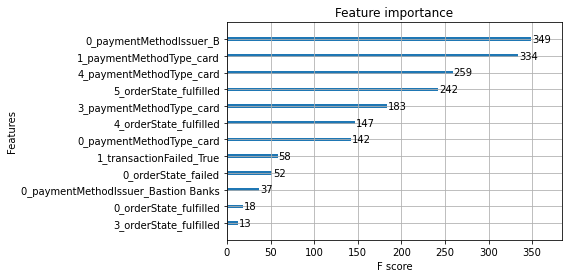

<Figure size 1280x144000 with 0 Axes>

In [403]:
#Accuracy 
accuracy = accuracy_score(onehot_y_test, onehot_prediction)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#Plotting to show the most important features
plot_importance(clf, max_num_features= 19)
plt.figure(figsize=(16, 1800), dpi=80)
plt.show()



I am going to employ the same method again to 

In [404]:
#pick the features with F1> 20 to keep

features = onehot[['0_paymentMethodIssuer_Solace Banks', '0_paymentMethodIssuer_Her Majesty Trust', '3_orderState_fulfilled', '0_paymentMethodType_card', '0_paymentMethodIssuer_Vertex Bancorp',
                   '0_paymentMethodProvider_JCB 16 digit', '4_orderState_fulfilled', '2_paymentMethodType_card', '0_paymentMethodProvider_Mastercard', 
                   '0_paymentMethodIssuer_Rose Bancshares', '0_paymentMethodIssuer_Grand Credit Corporation', '3_paymentMethodType_card',
                   '1_paymentMethodType_card', '2_orderState_fulfilled', '1_paymentMethodProvider_JCB 16 digit', '0_paymentMethodRegistrationFailure_True',
                   '1_orderState_fulfilled', '0_paymentMethodProvider_VISA 16 digit', '0_paymentMethodType_paypal', ]]

#Doing this, we cut the dimentionality of the onehot encoded catagorical vars by a factor of 150 times at the cost of only 1-2% accuracy cost.


In [405]:
#Concat the features list to the numeric features to get our final df to apply ML to for an inbalanced binary classification problem.
df_features = pd.concat([features, df], axis=1)

# Train Model

In [406]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features.drop(['fraudulent'], axis = 1), df_features['fraudulent'], stratify= df_features['fraudulent'], test_size=0.20, random_state=1, shuffle=True)


In [407]:
# fit xgboost on an imbalanced classification dataset

#Define model as unbalance classifier with ratio defined in the EDA section
model =XGBClassifier(max_depth=3, learning_rate=0.0025, n_estimators=500, objective='binary:logistic', booster='gbtree', scale_pos_weight=0.375)
print(model)
XGB=model.fit(X_train,y_train)


prediction=XGB.predict(X_test)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.0025, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.375, seed=None,
              silent=None, subsample=1, verbosity=1)


In [408]:
#Find the metrics for accuracy
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

       False       0.72      0.95      0.82        22
        True       0.80      0.33      0.47        12

    accuracy                           0.74        34
   macro avg       0.76      0.64      0.65        34
weighted avg       0.75      0.74      0.70        34

[[21  1]
 [ 8  4]]


In [409]:
accuracy = accuracy_score(y_test, prediction)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.53%


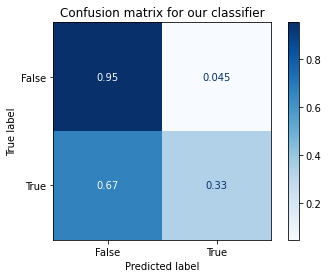

In [410]:
#A more colourful version of the confusion matrix for clarity
matrix = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

Odd. the catagorical variables alone outperform the same as with the numerics.
Maybe the catagorical vars are being overpowered by transforming them to int. 

We could try weight of evidence encoding (works well for the loan default classification kaggle challenge) 
instead of onehot. (ran out of time to try, would be interesting though!).


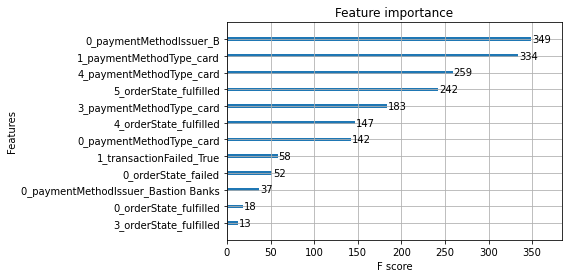

<Figure size 1280x144000 with 0 Axes>

In [411]:
plot_importance(clf, max_num_features= 30)
plt.figure(figsize=(16, 1800), dpi=80)
plt.show()

It seems the inferanced are dominated by the categorical variables, with the most important features being the payment method issuer, if payment was by card, if the order was fulfilled and if the transaction failed.

This could potentially show an overemphisis of the categorical variables, in the final section I will dicuss some methods that could be used to fix this if I had more time to improve the model.


I will also quickly trial some simple ML methods such as an SVM, logistic regressor ect to see if our result can be beaten for accuracy. 

In [412]:
#Implimenting SVM on data 
from sklearn import svm

model_svm = svm.SVC(kernel='linear', C = 1.0)
model_svm.fit(X_train,y_train)

prediction_svm = model_svm.predict(X_test)

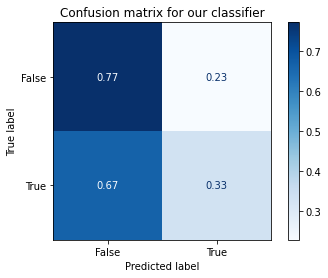

In [413]:
matrix = plot_confusion_matrix(model_svm, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()


Substandard accuracy when compared to XGboost, will next try Logistic regression 

In [414]:

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


scaler = preprocessing.StandardScaler().fit(X_train)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [415]:
#Accuracy of simple logistic regression
print("Accuracy: ", pipe.score(X_test, y_test))

Accuracy:  0.6470588235294118


Still worse than XGBoost. Although I wont here, these models could be combined in a metaclass to create an ensemble to improve accuracy. Finally will try naive bayes, showing a roughly 65% accuracy.

In [416]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d"
% (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 34 points : 10


# Next steps 

1) The location data seemed to be a potential goldmine for spotting fraud, but too complex to use to its full extent in the time period. For a longer attempt, I would produce a knowledge graph of known adresses of fraud committing, and take an attempt at building up a huristic model of fraud mapping, as shown by demonstrations from the quantexa team.


2) I would like to train other models on the data to analyse performance of other classifiers. Although my intuitions lead me to believe XGboost would provide good accuracy, the high non liniarity of some features could mean SVM's with a polynomial kernal could perform better. 

Ultimately, it would probably be best to protype a good 5 different models such as logistic regression ect, and produce an ensemble model for the final classification.

3) It would have been interesting as a further step of EDA to perform clustering of the feature vectors to perform feature selection with greater automation. It would also be another way of confirming my hypothesis that the feature importance is dependant on the ID of the purchance (the importance of using the card the first time was shown to be more important than the 4th, or any other time) other than just using XGBoost.